<a href="https://githubtocolab.com/Astolfo2332/HyM_prediction/blob/main/0.2_Limpieza_de_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Limpieza de datos

In [ ]:
from google.colab import files

files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
'chmod 600 /root/.kaggle/kaggle.json' #Para proteger la información

In [ ]:
!kaggle competitions download -c h-and-m-personalized-fashion-recommendations -f articles.csv
!kaggle competitions download -c h-and-m-personalized-fashion-recommendations -f customers.csv
!kaggle competitions download -c h-and-m-personalized-fashion-recommendations -f transactions_train.csv
! mkdir Data
! unzip transactions_train.csv.zip -d Data
! unzip customers.csv.zip -d Data
! unzip articles.csv.zip -d Data


## 1. Generación de datos faltantes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn import preprocessing as ps
from difflib import SequenceMatcher
import csv

En este caso vamos a generar 5% de datos faltantes en las columnas de interés, así que aleatoriamente se desorganizan los datasets antes de unirlos en uno y se eliminaran en parte de transacciones el 5% de artículos comprados, en clientes; la edad y finalmente en artículos; el tipo de articulo.

In [2]:
client=pd.read_csv("Data/customers.csv")

In [3]:
sells=pd.read_csv("Data/transactions_train.csv")

In [4]:
articles=pd.read_csv("Data/articles.csv")

In [5]:
def makeitrandom(client,sells,articles):
    client=client.sample(frac=1) #Desorganizamos las filas
    sells=sells.sample(frac=1)
    articles=articles.sample(frac=1)
    client=client.reset_index(drop=True) #Reiniciamos los index
    sells=sells.reset_index(drop=True)
    articles=articles.reset_index(drop=True)
    return client,sells,articles

In [6]:
client,sells,articles=makeitrandom(client,sells,articles)

In [7]:
f=0.05
n_client=int(len(client)*f)
n_sells=int(len(sells)*f)
n_articles=int(len(articles)*f)

In [8]:
client.loc[:n_client,"age"]=np.nan
sells.loc[:n_sells,"article_id"]=np.nan
articles.loc[:n_articles,"product_type_name"]=np.nan

In [9]:
client,sells,articles=makeitrandom(client,sells,articles)

In [10]:
def faltap(data):
    total      = data.isnull().sum().sort_values(ascending=False)
    percent    = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
    missing  = pd.concat([total,percent],axis=1,keys=["Total","Percent"])
    return missing

In [11]:
faltap(client)

,Total,Percent
Active,907576,66.150819
FN,895050,65.237831
age,83679,6.099141
fashion_news_frequency,16009,1.166854
club_member_status,6062,0.441843
customer_id,0,0.000000
postal_code,0,0.000000


In [12]:
faltap(sells)

,Total,Percent
article_id,1589417,5.000003
t_dat,0,0.000000
customer_id,0,0.000000
price,0,0.000000
sales_channel_id,0,0.000000


In [13]:
faltap(articles)

,Total,Percent
product_type_name,5278,5.000853
detail_desc,416,0.394156
perceived_colour_master_name,0,0.000000
garment_group_name,0,0.000000
garment_group_no,0,0.000000
section_name,0,0.000000
section_no,0,0.000000
index_group_name,0,0.000000
index_group_no,0,0.000000
index_name,0,0.000000


## 2. agrupación de datos y eliminación de variables

En este caso vamos a proceder a primero hacer una correlación con las compras y los artículos de cada cliente, para generar un dataframe, que nos resuma los artículos comprados Por cliente, el dataset al ser tan grande primero se le hará una reducción a las transacciones y una división entre train y test por fechas

In [14]:
a=len(sells)//2
sells=sells.loc[0:a]
sells.index=sells.customer_id.values
del(sells["sales_channel_id"])
sells.head()

,t_dat,customer_id,article_id,price
a1d3c7aa6d3f7539ee7f2665c2d9e4b35df4ad99869d954bf24c319f2ff08d3f,2019-12-19,a1d3c7aa6d3f7539ee7f2665c2d9e4b35df4ad99869d95...,757971001.0,0.022017
5209e2e0541719b69a3d1c6207df04bf86f253a596b5cd6953eb31d7c03c65ac,2019-03-26,5209e2e0541719b69a3d1c6207df04bf86f253a596b5cd...,678696001.0,0.025407
ea7e7a7f0efbd705f9c341555a8e6c5df5790a2e5053c2f434c70d569078b352,2018-09-26,ea7e7a7f0efbd705f9c341555a8e6c5df5790a2e5053c2...,621756004.0,0.050831
01d2526840c6b63b5db03e9e410ffe5611b78c130a36a088eeab412aac664da2,2019-05-02,01d2526840c6b63b5db03e9e410ffe5611b78c130a36a0...,NaN,0.024017
fdaa298abb23a8e175199708373a163577a99af9bda5267d1e47b82009246b6d,2020-04-02,fdaa298abb23a8e175199708373a163577a99af9bda526...,762130001.0,0.033881


In [15]:
client.index=client.customer_id.values
del(client["postal_code"])
del(client["customer_id"])
client.head()

,FN,Active,club_member_status,fashion_news_frequency,age
d3e7259b117e4c6ad883f99d6cc2fbba6468db6e952415ca1bda201c207285be,1.0,1.0,ACTIVE,Regularly,33.0
83d8e6dfa71258a1fc4eafde2d7e6ab6b5a36d60038b2f4f2b689d1588036f52,1.0,1.0,ACTIVE,Regularly,31.0
1e9c40f308a2159beed0b321badecfa64445051c3e98919ba5ab2d299589fbad,NaN,NaN,PRE-CREATE,NONE,45.0
d83babf77510233025261405fa66735ba8398cb9dff333737185ba03d40198e2,NaN,NaN,PRE-CREATE,NONE,40.0
5584a1d0c2e24c4eb1872106ca735ea1fa9b4a8df5af2418e666ae453cd6daa5,1.0,1.0,ACTIVE,Regularly,57.0


In [16]:
sells=sells.join(client)
sells.head()

,t_dat,customer_id,article_id,price,FN,Active,club_member_status,fashion_news_frequency,age
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,2019-07-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,745232001.0,0.021169,NaN,NaN,ACTIVE,NONE,49.0
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,2019-07-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,607642008.0,0.012695,NaN,NaN,ACTIVE,NONE,49.0
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,2020-03-21,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,859416011.0,0.014390,NaN,NaN,ACTIVE,NONE,49.0
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,2020-03-21,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,887593002.0,0.021593,NaN,NaN,ACTIVE,NONE,49.0
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,2019-11-28,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,785710001.0,0.024407,NaN,NaN,ACTIVE,NONE,49.0


In [17]:
sells=sells.reset_index(drop=True)

In [18]:
sells.head()

,t_dat,customer_id,article_id,price,FN,Active,club_member_status,fashion_news_frequency,age
0,2019-07-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,745232001.0,0.021169,NaN,NaN,ACTIVE,NONE,49.0
1,2019-07-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,607642008.0,0.012695,NaN,NaN,ACTIVE,NONE,49.0
2,2020-03-21,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,859416011.0,0.014390,NaN,NaN,ACTIVE,NONE,49.0
3,2020-03-21,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,887593002.0,0.021593,NaN,NaN,ACTIVE,NONE,49.0
4,2019-11-28,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,785710001.0,0.024407,NaN,NaN,ACTIVE,NONE,49.0


## 2.1 Relleno de datos vacíos  

En este caso vamos a reemplazar los datos faltantes, en el caso de el articulo, fashion_news, con la moda, el FN y active con 0. Y age con el promedio.

In [19]:
sells["article_id"].fillna(sells.article_id.mode()[0], inplace=True)
sells["FN"].fillna(0, inplace=True)
sells["Active"].fillna(0, inplace=True)
sells["club_member_status"].fillna(sells.club_member_status.mode()[0], inplace=True)
sells["fashion_news_frequency"].fillna(sells.fashion_news_frequency.mode()[0], inplace=True)
sells["age"].fillna(int(sells.age.mean()), inplace=True)

In [20]:
sells.isnull().sum()

t_dat                     0
customer_id               0
article_id                0
price                     0
FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    0
age                       0
dtype: int64

## 2.2 Filtrado de datos y concatenación final

Ahora vamos a filtrar los artículos para las columnas que consideramos afecten más la compra futura, como es el tipo de articulo, color, la sección a la que pertenece (ya que de ahí podríamos inferir el genero del cliente)

In [21]:
sells.index=sells.article_id.values
sells.head()

,t_dat,customer_id,article_id,price,FN,Active,club_member_status,fashion_news_frequency,age
745232001.0,2019-07-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,745232001.0,0.021169,0.0,0.0,ACTIVE,NONE,49.0
607642008.0,2019-07-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,607642008.0,0.012695,0.0,0.0,ACTIVE,NONE,49.0
859416011.0,2020-03-21,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,859416011.0,0.014390,0.0,0.0,ACTIVE,NONE,49.0
887593002.0,2020-03-21,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,887593002.0,0.021593,0.0,0.0,ACTIVE,NONE,49.0
785710001.0,2019-11-28,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,785710001.0,0.024407,0.0,0.0,ACTIVE,NONE,49.0


In [22]:
articles.index=articles.article_id.values
del(articles["article_id"])

In [23]:
sells=sells.join(articles)
sells=sells.reset_index(drop=True)
sells.head()

,t_dat,customer_id,article_id,price,FN,Active,club_member_status,fashion_news_frequency,age,product_code,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,2019-07-14,000f7535bdc611ad136a9f04746d6b1431f50a7f60fbbe...,108775015.0,0.008458,0.0,0.0,ACTIVE,NONE,48.0,108775,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,2019-07-14,000f7535bdc611ad136a9f04746d6b1431f50a7f60fbbe...,108775015.0,0.008458,0.0,0.0,ACTIVE,NONE,48.0,108775,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,2018-09-29,001ae5408a043f64bccd32beffe2730151414cbdf18a6e...,108775015.0,0.006763,1.0,1.0,ACTIVE,Regularly,50.0,108775,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,2018-09-29,001ae5408a043f64bccd32beffe2730151414cbdf18a6e...,108775015.0,0.006763,1.0,1.0,ACTIVE,Regularly,50.0,108775,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
4,2019-02-18,002da1d307ae48e1b8528792f62117e43a911ed0750195...,108775015.0,0.008458,1.0,1.0,ACTIVE,Regularly,21.0,108775,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [24]:
sells.index=pd.to_datetime(sells.t_dat)
del(sells["t_dat"])
sells.head()

,customer_id,article_id,price,FN,Active,club_member_status,fashion_news_frequency,age,product_code,prod_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
t_dat,,,,,,,,,,,,,,,,,,,,,
2019-07-14,000f7535bdc611ad136a9f04746d6b1431f50a7f60fbbe...,108775015.0,0.008458,0.0,0.0,ACTIVE,NONE,48.0,108775,Strap top,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2019-07-14,000f7535bdc611ad136a9f04746d6b1431f50a7f60fbbe...,108775015.0,0.008458,0.0,0.0,ACTIVE,NONE,48.0,108775,Strap top,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2018-09-29,001ae5408a043f64bccd32beffe2730151414cbdf18a6e...,108775015.0,0.006763,1.0,1.0,ACTIVE,Regularly,50.0,108775,Strap top,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2018-09-29,001ae5408a043f64bccd32beffe2730151414cbdf18a6e...,108775015.0,0.006763,1.0,1.0,ACTIVE,Regularly,50.0,108775,Strap top,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2019-02-18,002da1d307ae48e1b8528792f62117e43a911ed0750195...,108775015.0,0.008458,1.0,1.0,ACTIVE,Regularly,21.0,108775,Strap top,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [25]:
sells.tail()

,customer_id,article_id,price,FN,Active,club_member_status,fashion_news_frequency,age,product_code,prod_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
t_dat,,,,,,,,,,,,,,,,,,,,,
2020-09-15,38155dba0255d0b6f8884b36dd05094d62c71ca9c10311...,956217002.0,0.059305,1.0,1.0,ACTIVE,Regularly,24.0,956217,Cartwheel dress,...,Jersey,A,Ladieswear,1,Ladieswear,18,Womens Trend,1005,Jersey Fancy,"Short, A-line dress in jersey with a round nec..."
2020-09-12,3bc6882c082b946310a6536c1c9a5f1581e95829c63877...,956217002.0,0.057983,1.0,1.0,ACTIVE,Regularly,66.0,956217,Cartwheel dress,...,Jersey,A,Ladieswear,1,Ladieswear,18,Womens Trend,1005,Jersey Fancy,"Short, A-line dress in jersey with a round nec..."
2020-09-14,3e8272741c39b3579424da34b2c8b752d2cce5010774d5...,956217002.0,0.059305,1.0,1.0,ACTIVE,Regularly,58.0,956217,Cartwheel dress,...,Jersey,A,Ladieswear,1,Ladieswear,18,Womens Trend,1005,Jersey Fancy,"Short, A-line dress in jersey with a round nec..."
2020-09-20,c89698e2626f3d98d8496e673c89ece5a8ee92914ee92d...,956217002.0,0.059305,1.0,1.0,ACTIVE,Regularly,53.0,956217,Cartwheel dress,...,Jersey,A,Ladieswear,1,Ladieswear,18,Womens Trend,1005,Jersey Fancy,"Short, A-line dress in jersey with a round nec..."
2020-09-14,cedd533807afaef98ca626a771d8c14986de84bdb43743...,956217002.0,0.059305,0.0,0.0,ACTIVE,NONE,57.0,956217,Cartwheel dress,...,Jersey,A,Ladieswear,1,Ladieswear,18,Womens Trend,1005,Jersey Fancy,"Short, A-line dress in jersey with a round nec..."


## 3 Transformación de variables categóricas a numéricas

In [31]:
var_categoricas = ['customer_id', 'club_member_status',"fashion_news_frequency","product_type_name","colour_group_name","index_group_name","section_name","prod_name","product_group_name","graphical_appearance_name","perceived_colour_value_name","perceived_colour_master_name","department_name","index_code","index_name","garment_group_name","detail_desc"]
encoder = ps.LabelEncoder()

for i in var_categoricas:
    
    sells[i] = encoder.fit_transform(sells[i])

sells.article_id=sells.article_id.astype(int)
sells["FN"]=sells["FN"].astype(int)
sells.Active=sells.Active.astype(int)
sells.age=sells.age.astype(int)
sells=sells.reset_index(drop=True)
print (sells.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15894163 entries, 0 to 15894162
Data columns (total 33 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   customer_id                   int64  
 1   article_id                    int32  
 2   price                         float64
 3   FN                            int32  
 4   Active                        int32  
 5   club_member_status            int64  
 6   fashion_news_frequency        int64  
 7   age                           int32  
 8   product_code                  int64  
 9   prod_name                     int32  
 10  product_type_no               int64  
 11  product_type_name             int64  
 12  product_group_name            int32  
 13  graphical_appearance_no       int64  
 14  graphical_appearance_name     int32  
 15  colour_group_code             int64  
 16  colour_group_name             int64  
 17  perceived_colour_value_id     int64  
 18  perceived_colour_val

Separamos directamente los datos de test y de train

In [32]:
sells

,customer_id,article_id,price,FN,Active,club_member_status,fashion_news_frequency,age,product_code,prod_name,...,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,rebuy
0,294,108775015,0.008458,0,0,0,1,48,108775,39155,...,0,6,1,2,16,43,1002,5,14008,0
1,294,108775015,0.008458,0,0,0,1,48,108775,39155,...,0,6,1,2,16,43,1002,5,14008,1
2,530,108775015,0.006763,1,1,0,3,50,108775,39155,...,0,6,1,2,16,43,1002,5,14008,1
3,530,108775015,0.006763,1,1,0,3,50,108775,39155,...,0,6,1,2,16,43,1002,5,14008,1
4,879,108775015,0.008458,1,1,0,3,21,108775,39155,...,0,6,1,2,16,43,1002,5,14008,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15894158,272379,956217002,0.059305,1,1,0,3,24,956217,7918,...,0,6,1,2,18,53,1005,6,29140,1
15894159,290185,956217002,0.057983,1,1,0,3,66,956217,7918,...,0,6,1,2,18,53,1005,6,29140,1
15894160,303378,956217002,0.059305,1,1,0,3,58,956217,7918,...,0,6,1,2,18,53,1005,6,29140,1
15894161,974887,956217002,0.059305,1,1,0,3,53,956217,7918,...,0,6,1,2,18,53,1005,6,29140,1


Para simplificar el problema vamos a cambiar el enfoque del problema, ahora vamos a intentar predecir la recompra de los artículos

In [28]:
sell_sorted = sells.sort_values(['customer_id', 'article_id'])
sells['rebuy'] = sell_sorted['article_id'].duplicated(keep='first')
sells['rebuy'] = sells['rebuy'].astype(int)


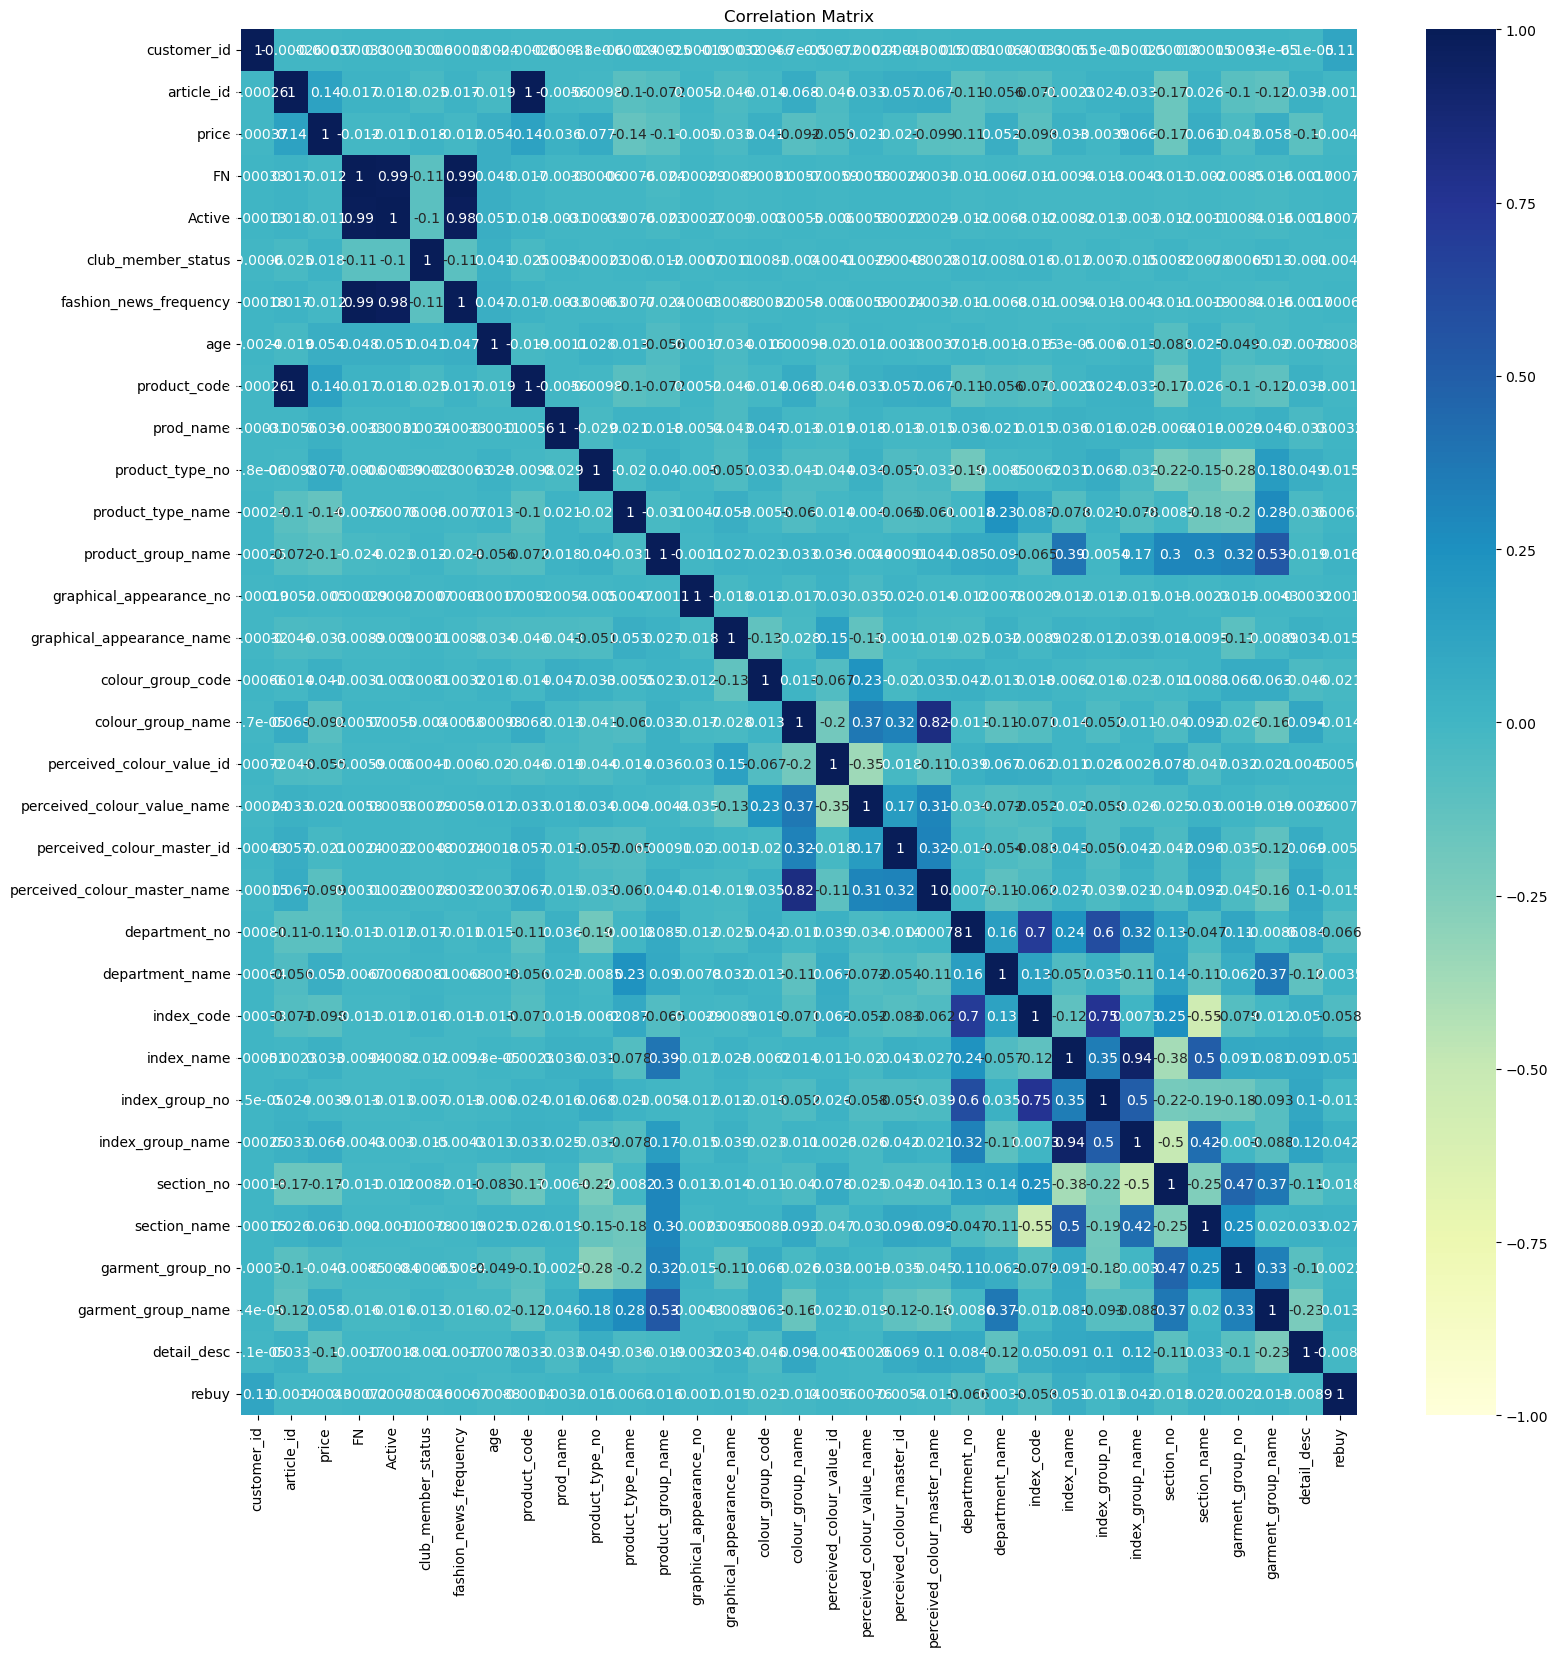

In [33]:
corr_matrix = sells.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
plt.show()

In [34]:
target_corr_df = pd.DataFrame(corr_matrix["rebuy"].sort_values(ascending=False))
target_corr_df 

,rebuy
rebuy,1.000000
customer_id,0.111928
index_name,0.051096
index_group_name,0.041857
section_name,0.027317
product_group_name,0.016342
graphical_appearance_name,0.015439
product_type_no,0.015132
garment_group_name,0.013455
product_type_name,0.006256


In [40]:
sells_final=sells[target_corr_df.index[:11]]
sells_final

,rebuy,customer_id,index_name,index_group_name,section_name,product_group_name,graphical_appearance_name,product_type_no,garment_group_name,product_type_name,perceived_colour_value_id
0,0,294,6,2,43,7,25,253,5,120,4
1,1,294,6,2,43,7,25,253,5,120,4
2,1,530,6,2,43,7,25,253,5,120,4
3,1,530,6,2,43,7,25,253,5,120,4
4,1,879,6,2,43,7,25,253,5,120,4
...,...,...,...,...,...,...,...,...,...,...,...
15894158,1,272379,6,2,53,5,25,265,6,32,4
15894159,1,290185,6,2,53,5,25,265,6,32,4
15894160,1,303378,6,2,53,5,25,265,6,32,4
15894161,1,974887,6,2,53,5,25,265,6,32,4


In [41]:
sells_final.to_csv("data_set.csv",index=False)